# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Google stock price (1d bars) for the year 2010

In [174]:
# Load Python Libraries
import math
import tensorflow as tf
from tensorflow import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

In [175]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [177]:
# Display the full dataset
display_df(data)

# Display basic info
print("\nData Info:")
print(data.info())

# Display summary statistics
print("\nSummary Statistics:")
print(data.describe())

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0



Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191 entries, 0 to 190
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       191 non-null    object 
 1   Open       186 non-null    float64
 2   High       186 non-null    float64
 3   Low        186 non-null    float64
 4   Close      186 non-null    float64
 5   Adj Close  186 non-null    float64
 6   Volume     186 non-null    float64
dtypes: float64(6), object(1)
memory usage: 10.6+ KB
None

Summary Statistics:
             Open        High         Low       Close   Adj Close  \
count  186.000000  186.000000  186.000000  186.000000  186.000000   
mean    11.798960   11.909745   11.702088   11.818551   11.818551   
std      1.849073    1.833189    1.855930    1.844248    1.844248   
min      8.562406    8.847836    8.483452    8.819193    8.819193   
25%     10.225049   10.366955   10.127602   10.244477   10.244477   
50%     11.351078   11.430032  

In [178]:
# Index data by Date
data.set_index('Date', inplace=True)

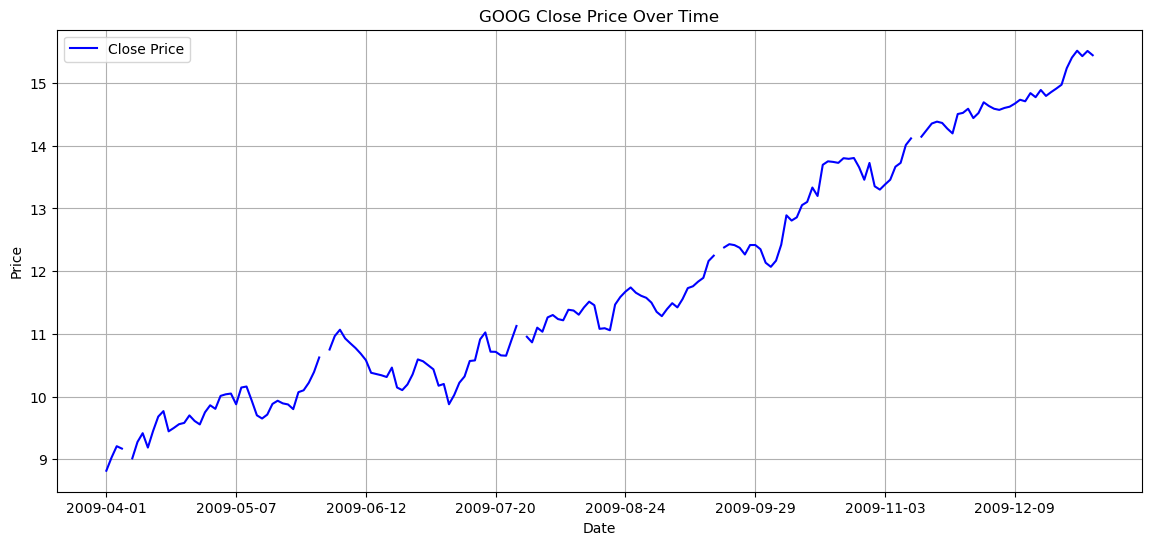

In [179]:
# Plot the closing price
data['Close'].plot(figsize=(14, 6), label='Close Price', color='blue')
plt.title('GOOG Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [181]:
# Check for null values
print(data.isnull().sum())


Open         5
High         5
Low          5
Close        5
Adj Close    5
Volume       5
dtype: int64


In [182]:
# forward fill missing values
data = data.ffill()

In [183]:
# Check for null values
print(data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


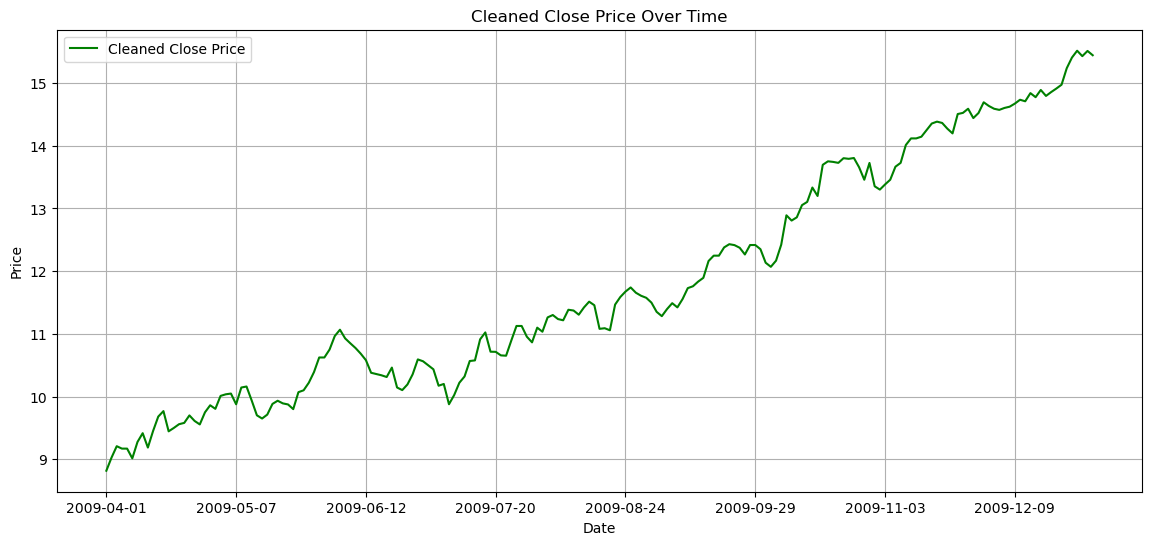

In [184]:
# Plot the cleaned Close Data
plt.figure(figsize=(14, 6))
data['Close'].plot(label='Cleaned Close Price', color='green')
plt.title('Cleaned Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [186]:
# Calculate 20-day bollinger bands

# Moving average and standard deviation
data['MA20'] = data['Close'].rolling(window=20).mean()
data['STD20'] = data['Close'].rolling(window=20).std()

# Upper and lower Bollinger Bands
data['UpperBB'] = data['MA20'] + (2 * data['STD20'])
data['LowerBB'] = data['MA20'] - (2 * data['STD20'])


In [187]:
# Remove rows with NaN bollinger bands
data = data.dropna(subset=['MA20', 'UpperBB', 'LowerBB'])

In [188]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'UpperBB', 'LowerBB']].copy()

# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

,Close,UpperBB,LowerBB
Date,,,
2009-04-29,9.750204,9.937823,8.853717
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898


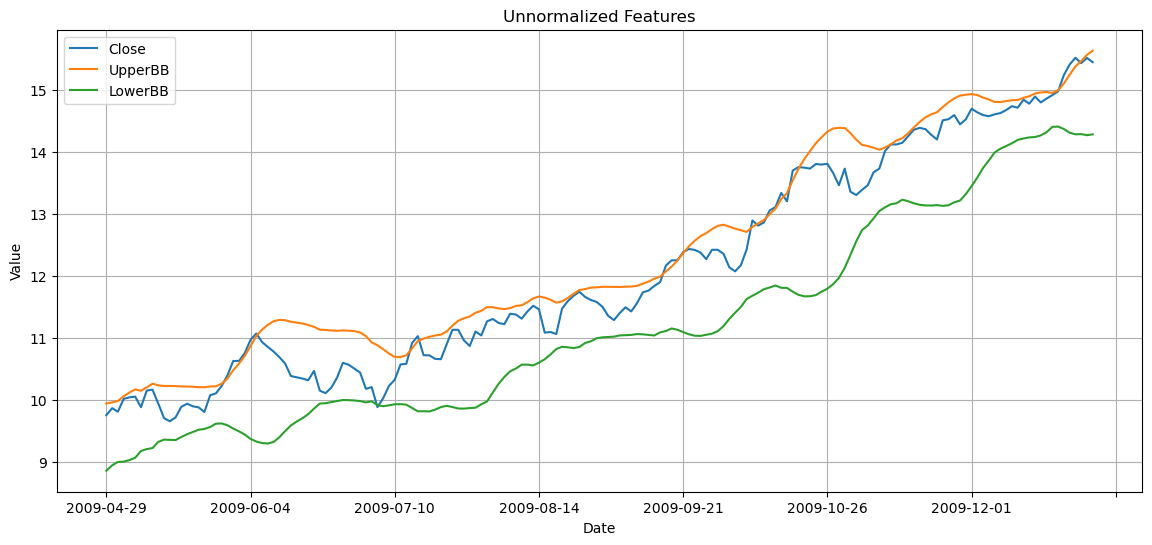

In [190]:
# Display & Plot Un-normalized Dataset
display_df(dataset.head())

dataset.plot(figsize=(14, 6), title="Unnormalized Features")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [191]:
# Normalize Dataset with StandardScaler
from sklearn.preprocessing import StandardScaler

normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)

for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[[col]].values  # ensure 2D
    scaled = normalizer.fit_transform(column_data)
    normed_dataset[col] = scaled.flatten()  # back to 1D series
    normlist.append(normalizer)


,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692


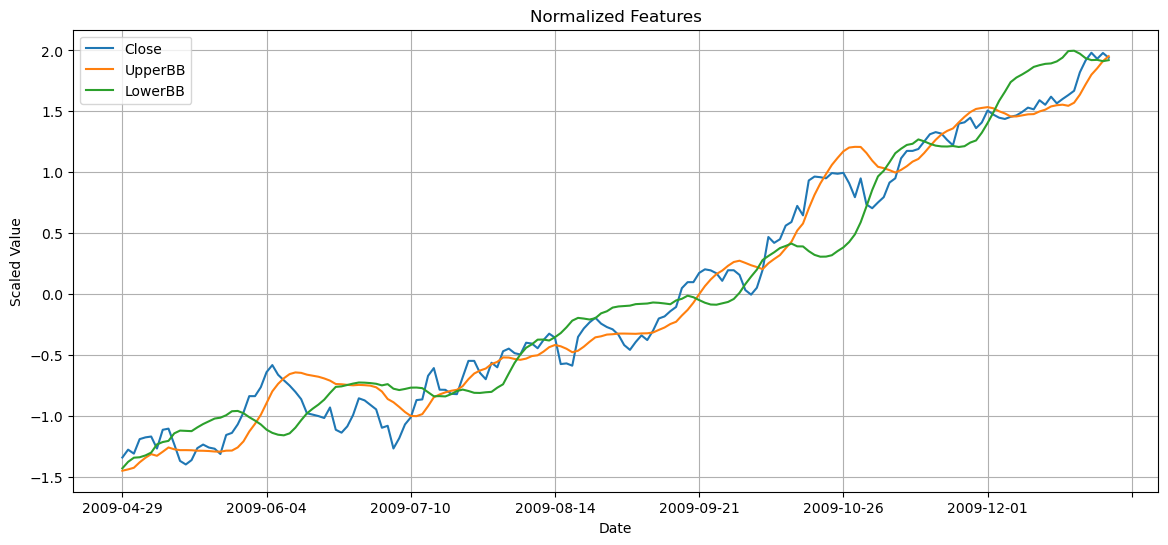

In [192]:
# Display & Plot Normalized Dataset
display_df(normed_dataset.head())

normed_dataset.plot(figsize=(14, 6), title="Normalized Features")
plt.xlabel("Date")
plt.ylabel("Scaled Value")
plt.grid(True)
plt.show()

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [194]:
# split dataset df into train (50%) and test (50%) datasets

split_idx = int(len(normed_dataset) * 0.5)
train_df = normed_dataset.iloc[:split_idx].copy()
test_df = normed_dataset.iloc[split_idx:].copy()


In [195]:
# display train and test dfs (ensure no overlap)
print("Train set:")
display_df(train_df)

print("\nTest set:")
display_df(test_df)

Train set:


,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175



Test set:


,Close,UpperBB,LowerBB
Date,,,
2009-08-31,-0.333839,-0.324508,-0.101821
2009-09-01,-0.418697,-0.324366,-0.098844
2009-09-02,-0.458183,-0.325247,-0.095058
2009-09-03,-0.393426,-0.326468,-0.082783
2009-09-04,-0.339151,-0.323058,-0.079844
2009-09-08,-0.377632,-0.322125,-0.077715
2009-09-09,-0.300814,-0.315388,-0.069243
2009-09-10,-0.200735,-0.294361,-0.071943
2009-09-11,-0.183505,-0.274560,-0.077222


In [196]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.to_numpy(dtype=float)
X_test = test_df.to_numpy(dtype=float)
# print the shape of X_train to remind yourself how many examples and features are in the dataset
print("X_train shape:", X_train.shape)
# track index to remember which feature is which
idx_close = 0
idx_bb_upper = 1
idx_bb_lower = 2

X_train shape: (86, 3)


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [199]:
# @keras.saving.register_keras_serializable() - not exporting
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()

        # Define model layers
        model = keras.Sequential([
            keras.layers.Input(shape=(state_size,)),
            keras.layers.Dense(64, activation='relu'),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(action_size, activation='linear')
        ])

        # Compile model
        model.compile(
            loss='mse',
            optimizer=keras.optimizers.Adam(learning_rate=0.001)
        )

        # Save model to DQN instance
        self.model = model


### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [201]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size  # How many days of historical data do we want to include in our state representation?
        self.num_features = num_features  # How many training features do we have?
        self.state_size = window_size * num_features  # State size = features per day * number of days
        self.action_size = 3  # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000)  # Experience replay buffer
        self.inventory = []  # Track open trades
        self.model_name = model_name  # Filename for loading checkpoint
        self.test_mode = test_mode  # Test mode flag

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_decay = 0.95
        self.epsilon_min = 0.01

        if test_mode:
            self.model = keras.models.load_model(model_name)
        else:
            self.model = DQN(self.state_size, self.action_size).model

    # Build the DQN model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model

    # Predict Q-values for a given state
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))

    # Fit model to target Q-values
    def fit_model(self, input_state, target_output):
        return self.model.fit(
            input_state.flatten().reshape(1, self.state_size),
            target_output.reshape(1, self.action_size),  # <-- FIXED LINE
            epochs=1,
            verbose=0
        )

    # Choose action using epsilon-greedy policy
    def act(self, state):
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randint(0, self.action_size - 1)
        q_values = self.get_q_values_for_state(state)
        return int(np.argmax(q_values))

    def exp_replay(self, batch_size, losses):
        losses = []
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
    
        for state, action, reward, next_state, done in mini_batch:
            q_current = self.get_q_values_for_state(state)
            if done:
                q_current[0][action] = reward
            else:
                q_next = self.get_q_values_for_state(next_state)
                q_current[0][action] = reward + self.gamma * np.max(q_next)
    
            history = self.fit_model(state, q_current[0])
            losses += history.history['loss']
    
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
        return losses


In [202]:
import os
print(os.path.exists('model_ep2.keras'))  # should return True if model file exists

True


# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [205]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

# returns an an n-day state representation ending at time t
def get_state(data, t, n):
    # If there aren't enough past time steps, pad with t=0 (beginning state)
    start_idx = max(0, t - n + 1)
    window = data[start_idx:t+1]  # inclusive of t

    # If the window is smaller than n, prepend first row to pad
    if len(window) < n:
        pad = [data[0]] * (n - len(window))
        window = pad + list(window)

    # Flatten and apply sigmoid to each feature value
    flattened = [sigmoid(x) for day in window for x in day]
    return np.array(flattened)


### Training Loop

In [207]:
# display the shape of your training data in order to remind yourself how may features and examples there are in your training set
print("Training data shape:", X_train.shape)

Training data shape: (86, 3)


In [208]:
keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor

window_size = 1

# instatiate the agent using the wndow size and the number of training features
import os

model_path = "best_model.keras"
if os.path.exists(model_path):
    agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=model_path)
else:
    # Fallback to last episode if best model doesn't exist yet
    agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f"model_ep{episode_count}.keras")



Running episode 0/4:   0%|          | 0/86 [00:00<?, ?it/s]

Buy: $9.75
Buy: $9.86
Buy: $9.81
Buy: $10.01
Buy: $10.04
Buy: $10.05
Buy: $9.88
Buy: $10.15
Buy: $10.16
Buy: $9.94
Buy: $9.70
Buy: $9.65
Buy: $9.71
Buy: $9.88
Buy: $9.93
Buy: $9.89
Buy: $9.88
Buy: $9.80
Buy: $10.07
Buy: $10.10
Buy: $10.22
Buy: $10.39
Buy: $10.62
Buy: $10.62
Buy: $10.75
Buy: $10.97
Buy: $11.07
Buy: $10.93
Buy: $10.85
Buy: $10.77
Buy: $10.68
Buy: $10.58
Buy: $10.38
Buy: $10.36
Buy: $10.34
Buy: $10.31
Buy: $10.46
Buy: $10.15
Buy: $10.10
Sell: $10.19 | Profit: $0.44
Sell: $10.36 | Profit: $0.49
Sell: $10.59 | Profit: $0.79
Sell: $10.56 | Profit: $0.55
Sell: $10.50 | Profit: $0.46
Sell: $10.44 | Profit: $0.39
Sell: $10.17 | Profit: $0.30
Sell: $10.20 | Profit: $0.06
Sell: $9.88 | Profit: -$0.28
Sell: $10.02 | Profit: $0.09
Sell: $10.22 | Profit: $0.52
Sell: $10.32 | Profit: $0.67
Sell: $10.57 | Profit: $0.85
Sell: $10.58 | Profit: $0.69
Sell: $10.91 | Profit: $0.98
Sell: $11.02 | Profit: $1.13
Sell: $10.72 | Profit: $0.84
Sell: $10.71 | Profit: $0.91
Sell: $10.66 | Profit: 

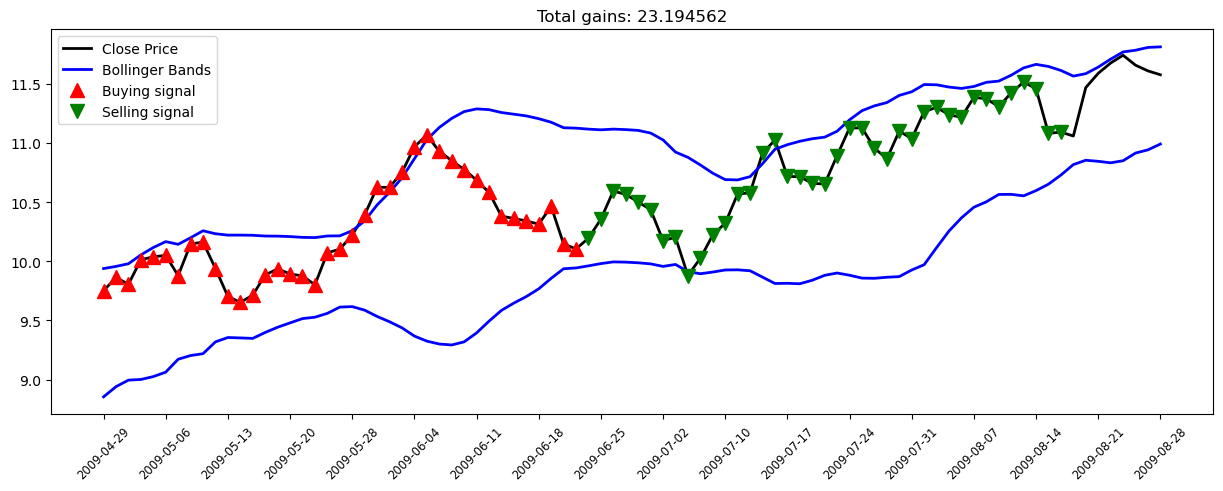

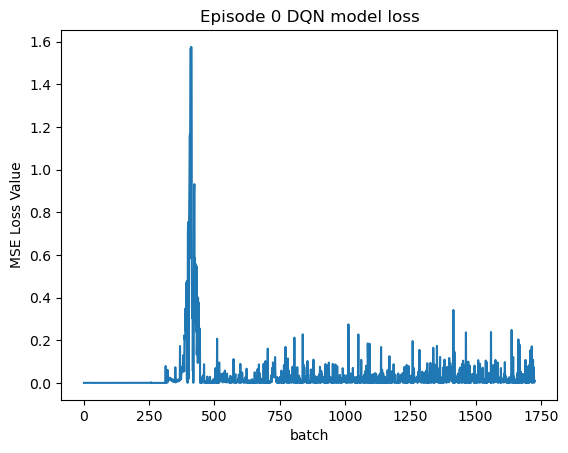

Running episode 1/4:   0%|          | 0/86 [00:00<?, ?it/s]

Buy: $9.81
Sell: $10.01 | Profit: $0.21
--------------------------------
Episode 1
Total Profit: $0.21
Total Winners: $0.21
Total Losers: $0.00
Max Loss: 44.08213424682617
Total Loss: 397.49570071346875
--------------------------------


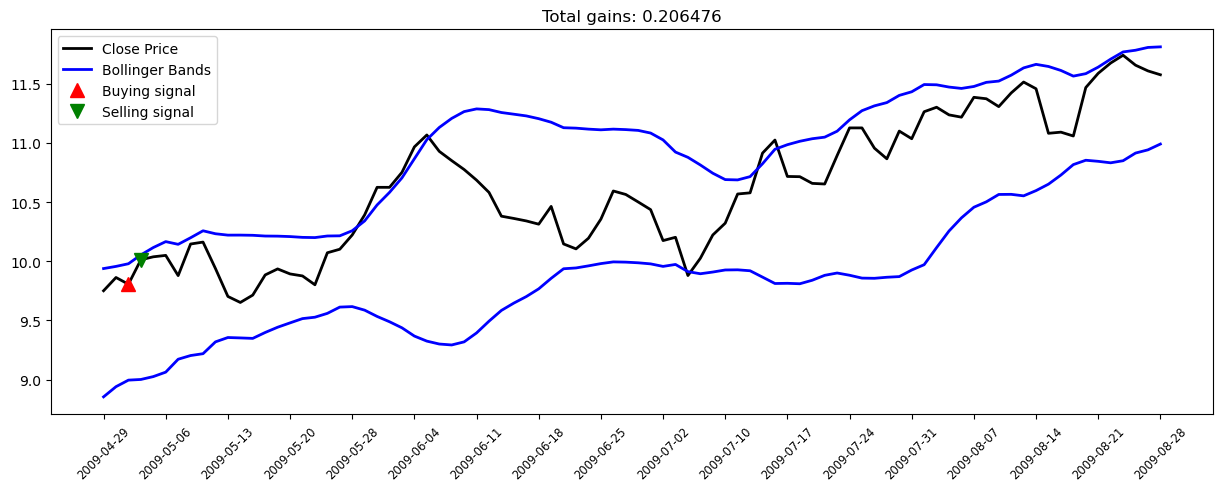

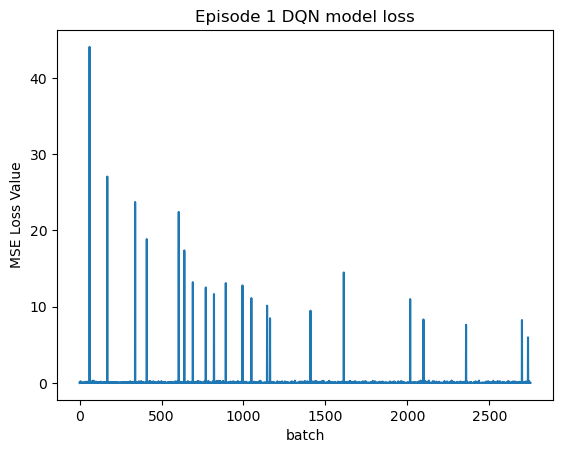

Running episode 2/4:   0%|          | 0/86 [00:00<?, ?it/s]

Buy: $10.62
Sell: $10.75 | Profit: $0.13
--------------------------------
Episode 2
Total Profit: $0.13
Total Winners: $0.13
Total Losers: $0.00
Max Loss: 5.578877925872803
Total Loss: 109.84328441855273
--------------------------------


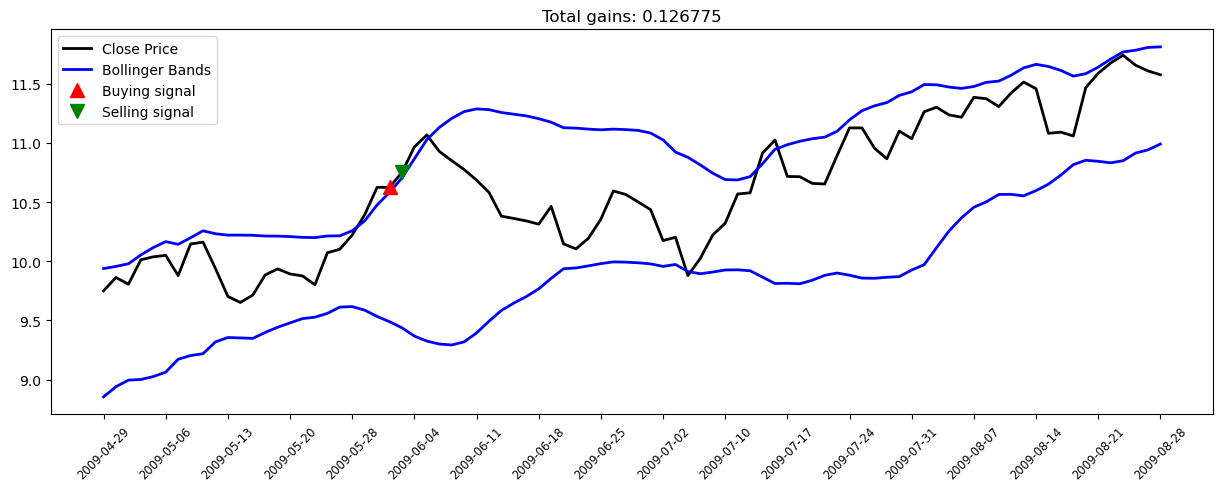

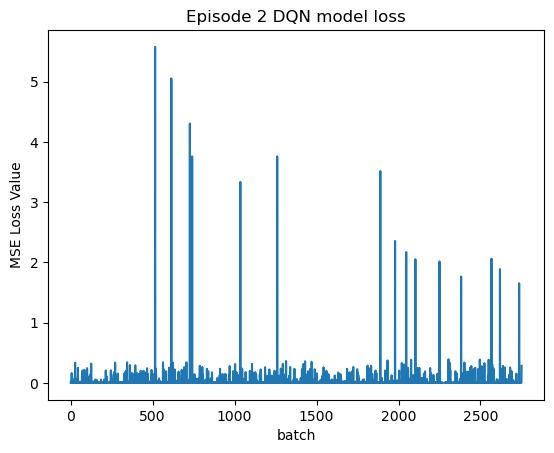

Running episode 3/4:   0%|          | 0/86 [00:00<?, ?it/s]

Buy: $9.81
Sell: $10.01 | Profit: $0.21
Buy: $10.05
Sell: $9.88 | Profit: -$0.17
Buy: $10.77
Sell: $10.68 | Profit: -$0.09
Buy: $10.44
Sell: $10.17 | Profit: -$0.26
--------------------------------
Episode 3
Total Profit: -$0.32
Total Winners: $0.21
Total Losers: -$0.52
Max Loss: 1.9839824438095093
Total Loss: 93.45397551085756
--------------------------------


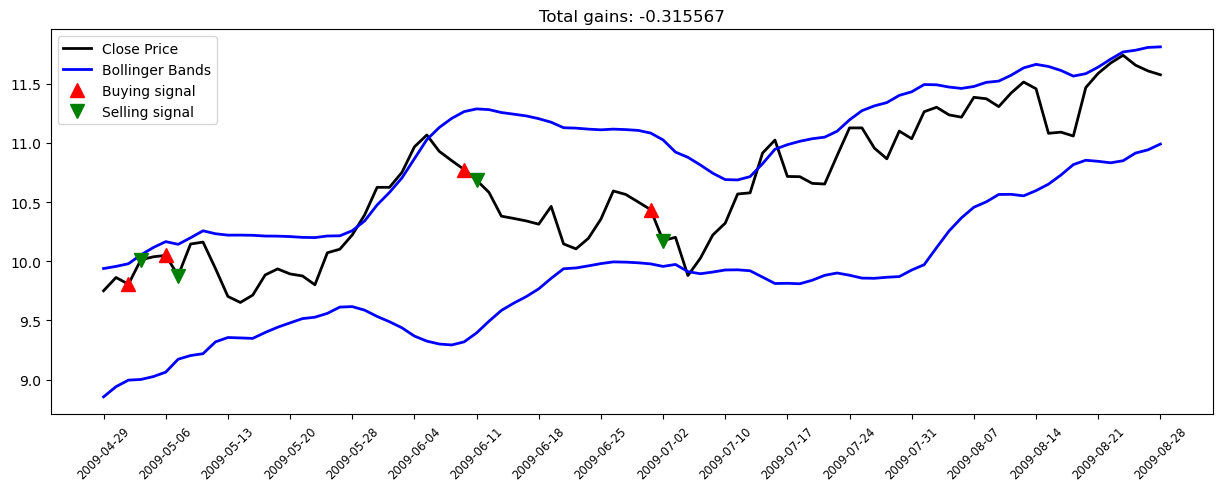

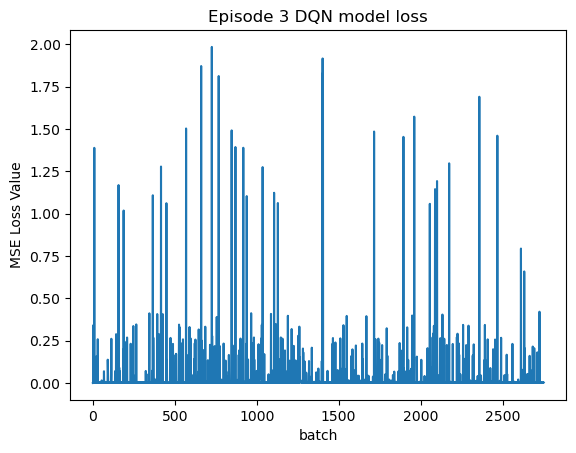

Running episode 4/4:   0%|          | 0/86 [00:00<?, ?it/s]

Buy: $9.75
Sell: $9.86 | Profit: $0.11
Buy: $10.04
Sell: $10.05 | Profit: $0.01
Buy: $9.70
Buy: $9.65
Sell: $9.71 | Profit: $0.01
Sell: $9.88 | Profit: $0.23
Buy: $9.80
Sell: $10.07 | Profit: $0.27
Buy: $11.47
Sell: $11.59 | Profit: $0.12
--------------------------------
Episode 4
Total Profit: $0.76
Total Winners: $0.76
Total Losers: $0.00
Max Loss: 4.111626148223877
Total Loss: 75.93879206959988
--------------------------------


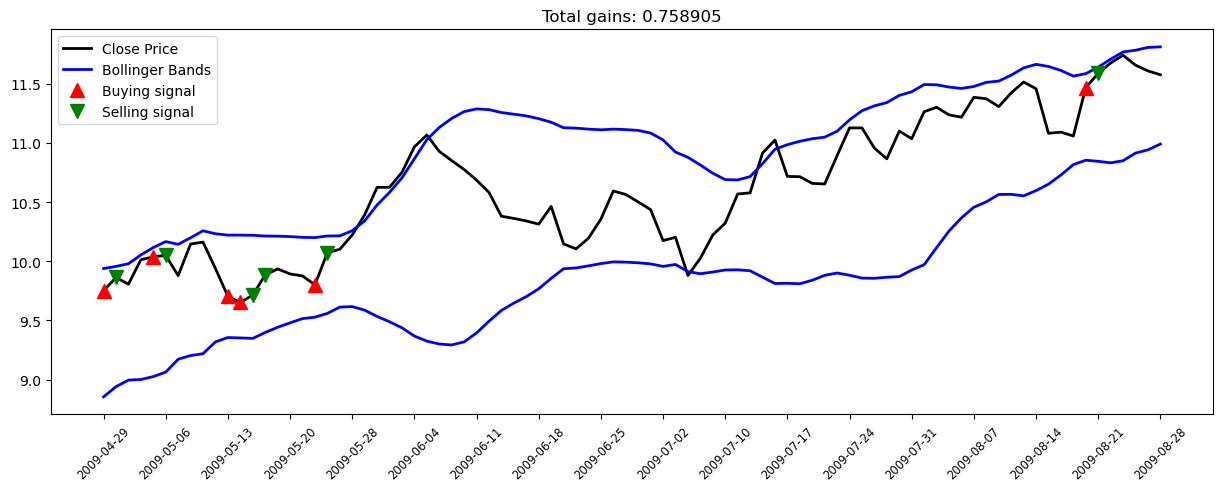

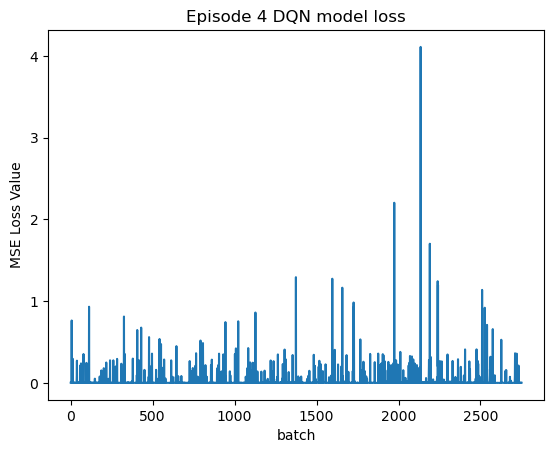

In [209]:
keras.config.disable_traceback_filtering()  # cleaner output

l = len(X_train)  # number of training examples (i.e. days)

batch_size = 32
episode_count = 4

# Extract normalizers from previously saved list
normalizer_close = normlist[idx_close]
normalizer_bb_upper = normlist[idx_bb_upper]
normalizer_bb_lower = normlist[idx_bb_lower]

# Inverse transform to get true price/Bollinger Band values
X_train_true_price = normalizer_close.inverse_transform(X_train[:, [idx_close]]).flatten()
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, [idx_bb_upper]]).flatten()
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, [idx_bb_lower]]).flatten()

batch_losses = []
num_batches_trained = 0

best_profit = float('-inf')

for e in range(episode_count + 1):
    state = get_state(X_train, 0, window_size)

    # Initialize tracking vars
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)
        next_state = get_state(X_train, t + 1, window_size) if t + 1 < l else state

        reward = 0

        if action == 1:  # buy
            buy_price = X_train_true_price[t]
            agent.inventory.append(buy_price)
            states_buy.append(t)
            print(f"Buy: {format_price(buy_price)}")

        elif action == 2 and len(agent.inventory) > 0:  # sell
            bought_price = agent.inventory.pop(0)
            sell_price = X_train_true_price[t]
            trade_profit = sell_price - bought_price
            reward = max(trade_profit, 0)
            total_profit += trade_profit

            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit

            states_sell.append(t)
            print(f"Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}")

        done = True if t == l - 1 else False

        # Store experience in memory
        agent.memory.append((state, action, reward, next_state, done))
        state = next_state

        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            if batch_losses[num_batches_trained:]:
                print(f'Max Loss: {max(batch_losses[num_batches_trained:])}')
                print(f'Total Loss: {sum(batch_losses[num_batches_trained:])}')
            print('--------------------------------')

            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

        # Fit model when enough experiences collected
        if len(agent.memory) >= batch_size:
            losses = agent.exp_replay(batch_size, batch_losses)
            batch_losses.extend(losses)

    if e % 2 == 0:
        if total_profit > best_profit:
            best_profit = total_profit
            agent.model.save("best_model.keras")


### Plot Training Loss

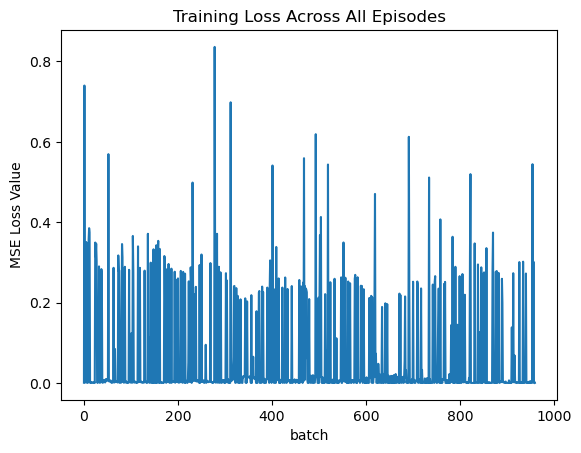

In [212]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, 'Training Loss Across All Episodes')

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [252]:
# debugging:
print("Sample state shape:", state.shape)
print("Model output:", agent.model.predict(state.reshape(1, -1)))

Sample state shape: (3,)
Model output: [[0.50849545 1.0708457  1.0777161 ]]


In [254]:
print(f"t={t}, action={action}, inventory={agent.inventory}")

t=84, action=2, inventory=[12.161664962768556, 12.247095108032228, 12.247095108032228, 12.378602027893066, 12.429909706115724, 12.414965629577637, 12.372873306274414, 12.266023635864258, 12.416708946228027, 12.416708946228027, 12.34995937347412, 12.134516716003418, 12.069260597229004, 12.167393684387209, 12.421939849853516, 12.89018440246582, 12.80649757385254, 12.858055114746094, 13.052078247070312, 13.103633880615234, 13.333024978637695, 13.198280334472656, 13.694917678833008, 13.75070858001709, 13.741494178771973, 13.726051330566406, 13.800521850585938, 13.790559768676758, 13.803510665893556, 13.6560640335083, 13.457059860229492, 13.72480583190918, 13.352950096130373, 13.299899101257324, 13.38209056854248, 13.457806587219238, 13.665029525756836, 13.726051330566406, 14.010235786437988, 14.1160888671875, 14.1160888671875, 14.143238067626951, 14.247845649719238, 14.353200912475586, 14.38333797454834, 14.36241626739502, 14.271258354187012, 14.195791244506836, 14.50438404083252, 14.52281

Buy: $11.50
Buy: $11.35
Buy: $11.28
Buy: $11.40
Buy: $11.49
Buy: $11.42
Buy: $11.56
Buy: $11.73
Buy: $11.76
Buy: $11.83
Buy: $11.89
Buy: $12.16
Buy: $12.25
Buy: $12.25
Buy: $12.38
Buy: $12.43
Buy: $12.41
Buy: $12.37
Buy: $12.27
Buy: $12.42
Buy: $12.42
Buy: $12.35
Buy: $12.13
Buy: $12.07
Buy: $12.17
Buy: $12.42
Buy: $12.89
Buy: $12.81
Buy: $12.86
Buy: $13.05
Buy: $13.10
Buy: $13.33
Buy: $13.20
Buy: $13.69
Buy: $13.75
Buy: $13.74
Buy: $13.73
Buy: $13.80
Buy: $13.79
Buy: $13.80
Buy: $13.66
Buy: $13.46
Buy: $13.72
Buy: $13.35
Buy: $13.30
Buy: $13.38
Buy: $13.46
Buy: $13.67
Buy: $13.73
Buy: $14.01
Buy: $14.12
Buy: $14.12
Buy: $14.14
Buy: $14.25
Buy: $14.35
Buy: $14.38
Buy: $14.36
Buy: $14.27
Buy: $14.20
Buy: $14.50
Buy: $14.52
Buy: $14.59
Buy: $14.44
Buy: $14.52
Buy: $14.69
Buy: $14.63
Buy: $14.59
Buy: $14.57
Buy: $14.60
Buy: $14.62
Buy: $14.67
Buy: $14.73
Buy: $14.71
Buy: $14.84
Buy: $14.77
Buy: $14.89
Buy: $14.79
Buy: $14.85
Buy: $14.91
Buy: $14.97
Sell: $15.23 | Profit: $3.74
Sell: $15.4

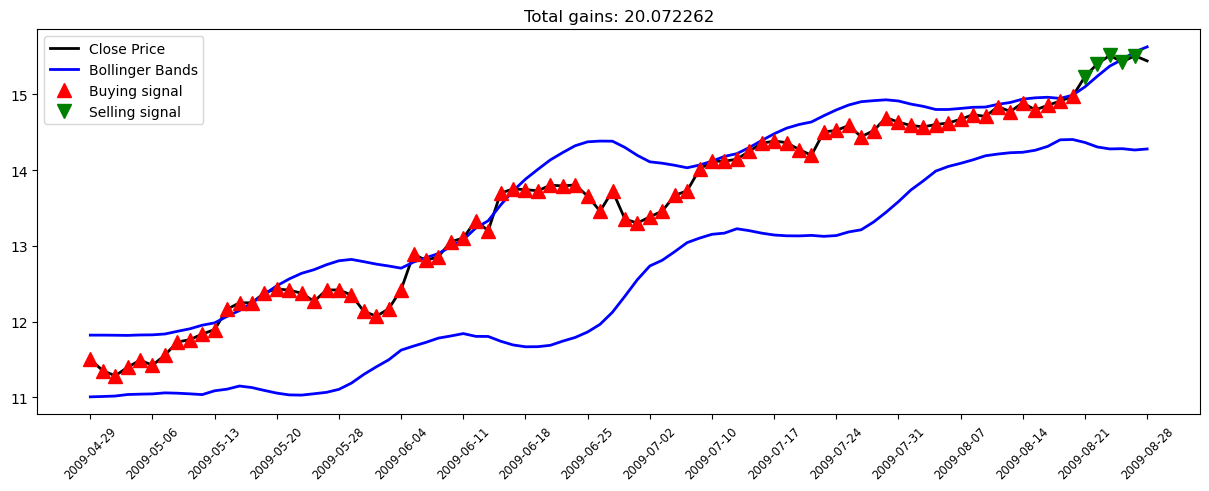

In [217]:
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size)
total_profit = 0
states_sell_test = []
states_buy_test = []

agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name="best_model.keras")
agent.inventory = []

X_test_true_price = normalizer_close.inverse_transform(X_test[:, [idx_close]])
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, [idx_bb_upper]])
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, [idx_bb_lower]])

for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size)

    if action == 1:
        agent.inventory.append(X_test_true_price[t][0])
        states_buy_test.append(t)
        print(f"Buy: {format_price(X_test_true_price[t][0])}")

    elif action == 2 and agent.inventory:
        bought_price = agent.inventory.pop(0)
        sell_price = X_test_true_price[t][0]
        trade_profit = sell_price - bought_price
        total_profit += trade_profit
        states_sell_test.append(t)
        print(f"Sell: {format_price(sell_price)} | Profit: {format_price(trade_profit)}")

    state = next_state

print('--------------------------------')
print(f'Total Profit on Test Set: {format_price(total_profit)}')
print('--------------------------------')
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit)


### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

Sell: $11.50 | Profit: -$0.66
--------------------------------
Total Profit: $37.80
--------------------------------
Buy: $11.35
--------------------------------
Total Profit: $37.80
--------------------------------
Buy: $11.28
--------------------------------
Total Profit: $37.80
--------------------------------
Buy: $11.40
--------------------------------
Total Profit: $37.80
--------------------------------
Buy: $11.49
--------------------------------
Total Profit: $37.80
--------------------------------
Buy: $11.42
--------------------------------
Total Profit: $37.80
--------------------------------
Buy: $11.56
--------------------------------
Total Profit: $37.80
--------------------------------
Buy: $11.73
--------------------------------
Total Profit: $37.80
--------------------------------
Buy: $11.76
--------------------------------
Total Profit: $37.80
--------------------------------
Buy: $11.83
--------------------------------
Total Profit: $37.80
-------------------------

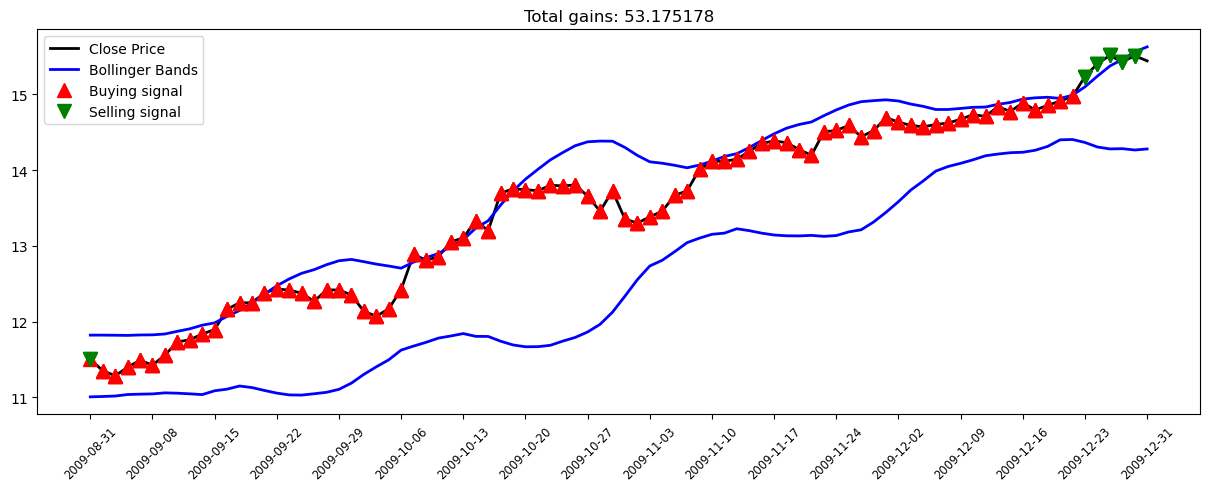

In [258]:
for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size)
    reward = 0

    if action == 1:  # buy
        buy_price = X_test_true_price[t][0]  # inverse transformed already
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0:  # sell
        bought_price = agent.inventory.pop(0)
        sell_price = X_test_true_price[t][0]
        reward = max(sell_price - bought_price, 0)
        total_profit += sell_price - bought_price
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}')

    if t == l_test - 1:
        done = True

    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('--------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('--------------------------------')

plot_behavior(
    X_test_true_price,
    X_test_true_bb_upper,
    X_test_true_bb_lower,
    states_buy_test,
    states_sell_test,
    total_profit,
    train=False
)
